## Idea:
 - Barlow Twins scales Images aggressively during resized cropping
 - Directly applying ImageNet features to the scaled crops is not ideal
 - Downscaling should revert the upscaling caused by Barlow Twins augmentations

### Visualize Problem

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from domainnet_dataset import DomainNetDataset
from lightly.transforms.byol_transform import BYOLView1Transform
from yasin_utils.data import TransformWrapper
from yasin_utils.image import plot_grid, imagenet_normalize
import torchvision.transforms.v2 as T
from torchvision.models.resnet import resnet50, ResNet50_Weights
import pytorch_lightning as L
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
SEED = 123456
_ = L.seed_everything(seed=SEED, workers=True)
BS = 64

Seed set to 123456


In [3]:
dataset = DomainNetDataset('/data/domainnet_v1.0', domains=['sketch'], transform=T.Compose([T.Resize((224,224)), T.ToTensor()]))
dataloader = DataLoader(dataset, batch_size=BS, shuffle=True)

/home/yasin/miniforge3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
batch = next(iter(dataloader))['image']

In [5]:
large_crop = T.Compose([
    T.RandomResizedCrop(224, scale=(0.08, 1.0)),
    T.ToTensor(),
])
small_crop = T.Compose([
    T.RandomResizedCrop(128, scale=(0.08, 1.0)),
    T.Pad(int((224-128)/2)),
    T.ToTensor(),
])

In [6]:
batch_lc = torch.cat([large_crop(img)[None] for img in batch], dim=0)
batch_sc = torch.cat([small_crop(img)[None] for img in batch], dim=0)

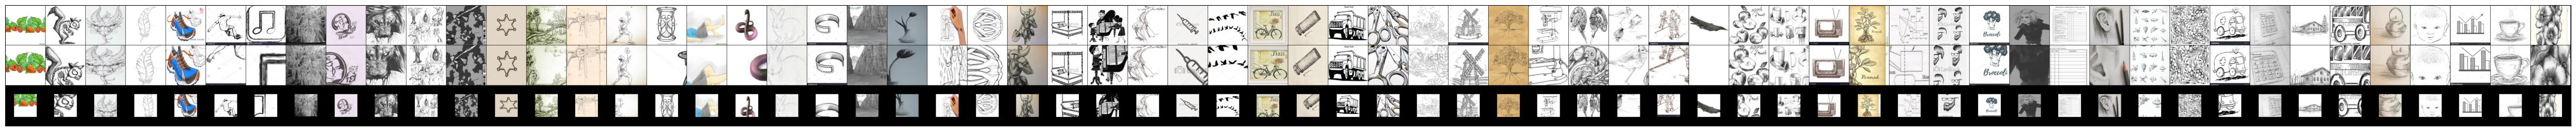

In [7]:
plot_grid(torch.cat([batch, batch_lc, batch_sc], dim=0), nrow=BS, zoom=10)

### Prepare Data

In [8]:
# large_crop = T.Compose([
#     T.RandomResizedCrop(224, scale=(0.08, 1.0)),
#     T.ToTensor(),
#     imagenet_normalize
# ])
# small_crop = T.Compose([
#     T.RandomResizedCrop(128, scale=(0.08, 1.0)),
#     T.ToTensor(),
#     imagenet_normalize
# ])

large_crop = BYOLView1Transform(input_size=224, gaussian_blur=0)
small_crop = BYOLView1Transform(input_size=128, gaussian_blur=0)

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    imagenet_normalize
])

/home/yasin/miniforge3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
full_dataset = DomainNetDataset('/data/domainnet_v1.0', domains=['real'])
dataset = Subset(full_dataset, indices=torch.randperm(len(full_dataset))[:60_000])

train_set, test_set = random_split(dataset, [50_000, 10_000])

train_set_lc = TransformWrapper(train_set, transform=large_crop)
train_set_sc = TransformWrapper(train_set, transform=small_crop)
train_set_nc = TransformWrapper(train_set, transform=test_transform)
test_set = TransformWrapper(test_set, transform=test_transform)

### Embed

In [10]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Identity()
model = model.cuda()
_ = model.eval()

In [11]:
def embed(model, dataset: Dataset, batch_size=256, num_workers=4, epochs=1):
    dataloader = DataLoader(dataset, batch_size, num_workers=num_workers)
    embeddings = []
    labels = []
    with torch.no_grad():
        for epoch in range(epochs):
            for batch in tqdm(dataloader):
                image, label = batch['image'].cuda(), batch['label']
                embedding = model(image)
                embeddings.append(embedding)
                labels.append(label)
    embeddings = torch.cat(embeddings, dim=0).contiguous()
    labels = torch.cat(labels, dim=0).contiguous()

    return embeddings.detach().cpu().numpy(), labels.detach().cpu().numpy()

In [12]:
train_embeddings_lc = embed(model, train_set_lc, batch_size=256)

100%|██████████| 196/196 [01:20<00:00,  2.43it/s]


In [13]:
train_embeddings_sc = embed(model, train_set_sc, batch_size=256)

100%|██████████| 196/196 [00:37<00:00,  5.29it/s]


In [12]:
train_embeddings_nc = embed(model, train_set_nc, batch_size=256)

100%|██████████| 196/196 [01:20<00:00,  2.43it/s]


In [13]:
test_embeddings = embed(model, test_set, batch_size=256)

100%|██████████| 40/40 [00:17<00:00,  2.28it/s]


### Linear Probing

In [14]:
def evaluate_set(train_embeddings, test_embeddings):
    clf = LogisticRegression(random_state=SEED, max_iter=1_000).fit(*train_embeddings)
    predictions = clf.predict(test_embeddings[0])
    accuracy = accuracy_score(test_embeddings[1], predictions)

    return accuracy

#### Large Crop (224px)

In [17]:
evaluate_set(train_embeddings_lc, test_embeddings)

0.7669

#### Small Crop (128px)

In [18]:
evaluate_set(train_embeddings_sc, test_embeddings)

0.748

#### No Crop (224px)

In [15]:
evaluate_set(train_embeddings_nc, test_embeddings)

0.7906